In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Input, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

tf.config.run_functions_eagerly(True)

videodemo = "/kaggle/input/audio-meta-files/VideoDemographics.csv"
aud = "/kaggle/input/cremad/AudioWAV"
gender = {'Male': 0, 'Female': 1}
metaf = pd.read_csv(videodemo, usecols=['ActorID', 'Sex'])
EPOCHS = 20

2025-08-06 06:25:13.185534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754461513.407370      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754461513.467079      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def create_dataframe():
    a = []
    gen = []
    mel_specs = []
    output_dir = '/kaggle/working/mel_specs'
    os.makedirs(output_dir, exist_ok=True)
    
    for file in tqdm(os.listdir(aud)):
        if file.endswith('.wav'):
            temp = file.split('_')
            actor_id = int(temp[0])
            actor_info = metaf[metaf['ActorID'] == actor_id]
            file_path = os.path.join(aud, file)
            if not actor_info.empty and os.path.exists(file_path):
                mel_spec = load_and_preprocess_audio(file_path)
                mel_path = os.path.join(output_dir, f'{os.path.splitext(file)[0]}.npy')
                np.save(mel_path, mel_spec)
                a.append(file_path)  
                gen.append(gender[actor_info['Sex'].iloc[0]])
                mel_specs.append(mel_path)
    
    audio = pd.DataFrame({'Audio': a, 'Gender': gen, 'MelSpec': mel_specs})
    return audio

In [3]:
def augment_audio(audio, sr=16000):
    noise = np.random.randn(len(audio))
    audio = audio + 0.005 * noise
    audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=np.random.uniform(-2, 2))
    audio = librosa.effects.time_stretch(audio, rate=np.random.uniform(0.8, 1.2))
    gain = np.random.uniform(0.8, 1.2)
    audio = audio * gain
    return audio

In [4]:
def frequency_masking(mel_spec, freq_mask_param=15, apply_mask=True):
    if not apply_mask:
        return mel_spec
    mel_spec = mel_spec.copy()
    num_mel_channels = mel_spec.shape[0]
    f = np.random.randint(0, freq_mask_param)
    f0 = np.random.randint(0, num_mel_channels - f)
    mel_spec[f0:f0 + f, :] = 0
    return mel_spec

In [5]:
def load_and_preprocess_audio(file_path, target_length=4, sr=16000, n_mels=256, hop_length=128):
    audio, _ = librosa.load(file_path, sr=sr)
    audio = augment_audio(audio, sr)
    target_samples = int(target_length * sr)
    if len(audio) < target_samples:
        audio = np.pad(audio, (0, target_samples - len(audio)), mode='constant')
    else:
        audio = audio[:target_samples]
    
    #Mel-spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, hop_length=hop_length)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
    #Applying frequency masking 50% of the time
    apply_mask = np.random.rand() > 0.5
    mel_spec_db = frequency_masking(mel_spec_db, freq_mask_param=15, apply_mask=apply_mask)
    mel_spec_db = mel_spec_db[..., np.newaxis]
    
    #Pitch
    pitches, magnitudes = librosa.piptrack(y=audio, sr=sr)
    pitch_values = pitches[pitches > 0]
    pitch = np.mean(pitch_values) if len(pitch_values) > 0 else 0
    pitch_std = np.std(pitch_values) if len(pitch_values) > 1 else 0
    pitch = (pitch - 50) / (500 - 50)
    pitch_std = (pitch_std - 0) / (500 - 0)
    
    #MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfccs = (mfccs - np.min(mfccs)) / (np.max(mfccs) - np.min(mfccs))
    mfcc_mean = np.mean(mfccs, axis=1)
    
    #Formant frequencies 
    formants = librosa.effects.preemphasis(audio)
    n_formants = 2
    formant_freqs = []
    for i in range(n_formants):
        try:
            formant = librosa.lpc(audio, order=4 + int(sr / 1000))
            roots = np.roots(formant)
            roots = roots[np.imag(roots) >= 0]
            freqs = np.angle(roots) * (sr / (2 * np.pi))
            freqs = freqs[freqs > 0]
            if len(freqs) > i:
                formant_freqs.append(freqs[i])
            else:
                formant_freqs.append(0)
        except:
            formant_freqs.append(0)
    formant_freqs = np.array(formant_freqs)
    formant_freqs = (formant_freqs - 200) / (2000 - 200)
    
    #RMSE 
    rmse = librosa.feature.rms(y=audio)[0]
    rmse_mean = np.mean(rmse)
    rmse_std = np.std(rmse)
    rmse_mean = (rmse_mean - 0) / (1 - 0)  
    rmse_std = (rmse_std - 0) / (1 - 0)  
    
    extra_features = np.array([
        pitch, pitch_std, rmse_mean, rmse_std
    ] + formant_freqs.tolist() + mfcc_mean.tolist())  # 4 + 2 + 13 = 19 features
    extra_features = extra_features[..., np.newaxis, np.newaxis]  # Shape: (19, 1, 1)
    extra_features = np.repeat(extra_features, mel_spec_db.shape[1], axis=1)  # Shape: (19, 501, 1)
    
    mel_spec_db = np.concatenate([mel_spec_db, extra_features], axis=0)  # Shape: (256 + 19, 501, 1) = (275, 501, 1)
    
    return mel_spec_db

In [6]:
def create_tf_dataset(df, batch_size=16, train=True):
    def load_mel_spec(mel_path):
        mel_spec = np.load(mel_path.numpy().decode('utf-8'))
        return mel_spec.astype(np.float32)
    
    def parse_data(gender, mel_path):
        mel_spec = tf.py_function(
            func=load_mel_spec,
            inp=[mel_path],
            Tout=tf.float32
        )
        mel_spec.set_shape((275, 501, 1)) 
        gender = tf.cast(gender, tf.float32)
        return mel_spec, gender

    dataset = tf.data.Dataset.from_tensor_slices(
        (df['Gender'].values, df['MelSpec'].values)
    )
    dataset = dataset.map(parse_data, num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = dataset.cache()
    if train:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [7]:
def build_model():
    inp = Input((275, 501, 1))  
    x = Conv2D(16, kernel_size=(3,3), activation="relu", padding='same')(inp)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(32, kernel_size=(3,3), activation="relu", padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(32, kernel_size=(3,3), activation="relu", padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(32, kernel_size=(3,3), activation="relu", padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)  
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.7)(x) 
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.7)(x)
    op = Dense(1, activation='sigmoid', name='Gender')(x)

    model = Model(inputs=inp, outputs=op)
    model.summary()
    return model

In [8]:
#Cosine Annealing Scheduler
class CosineAnnealingScheduler(tf.keras.callbacks.Callback):
    def __init__(self, T_max, eta_max, eta_min):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.epoch = 0

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + np.cos(np.pi * epoch / self.T_max)) / 2
        if isinstance(self.model.optimizer.learning_rate, tf.Variable):
            tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)
        else:
            self.model.optimizer.learning_rate = lr


100%|██████████| 7442/7442 [12:35<00:00,  9.85it/s]


Class Weights: {0: 0.9604679306171844, 1: 1.0429259745948314}


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 275, 501, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 275, 501, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 275, 501, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 137, 250, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 137, 250, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 137, 250, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 68, 125, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 68, 125, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 68, 125, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 34, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 34, 62, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 34, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 34, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 17, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Gender (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,289 (141.75 KB)

 Trainable params: 36,065 (140.88 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.4913 - loss: 1.5748
Epoch 1: val_accuracy improved from -inf to 0.53317, saving model to /kaggle/working/gendertask3.weights.h5
298/298 ━━━━━━━━━━━━━━━━━━━━ 76s 251ms/step - accuracy: 0.4913 - loss: 1.5738 - val_accuracy: 0.5332 - val_loss: 0.9113
Epoch 2/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.5335 - loss: 0.8556
Epoch 2: val_accuracy improved from 0.53317 to 0.54996, saving model to /kaggle/working/gendertask3.weights.h5
298/298 ━━━━━━━━━━━━━━━━━━━━ 67s 223ms/step - accuracy: 0.5335 - loss: 0.8555 - val_accuracy: 0.5500 - val_loss: 0.7523
Epoch 3/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.5387 - loss: 0.7382
Epoch 3: val_accuracy improved from 0.54996 to 0.60202, saving model to /kaggle/working/gendertask3.weights.h5
298/298 ━━━━━━━━━━━━━━━━━━━━ 66s 222ms/step - accuracy: 0.5388 - loss: 0.7381 - val_accuracy: 0.6020 - val_loss: 0.7090
Epoch 4/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 215

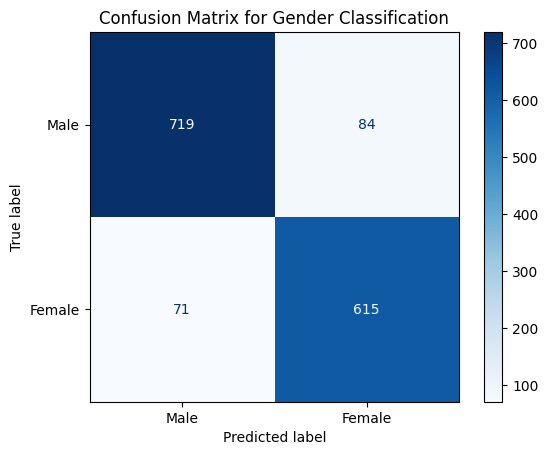

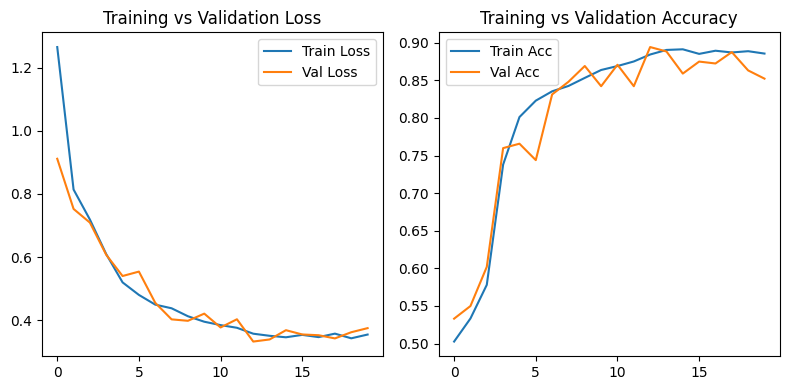

In [13]:
audio_df = create_dataframe()
train_df, test_df = train_test_split(audio_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

#Compute class weights to deal with gender imbalance
gender_counts = train_df['Gender'].value_counts().to_dict()
total = sum(gender_counts.values())
class_weights = {0: total / (2 * gender_counts[0]), 1: total / (2 * gender_counts[1])}
print("Class Weights:", class_weights)

train_ds = create_tf_dataset(train_df, train=True)
val_ds = create_tf_dataset(val_df, train=False)
test_ds = create_tf_dataset(test_df, train=False)

model = build_model()
cosine_annealer = CosineAnnealingScheduler(T_max=15, eta_max=0.001, eta_min=1e-6)
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
checkpoint = ModelCheckpoint(
    '/kaggle/working/gendertask3.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10, 
    restore_best_weights=True,
    mode='max',
    verbose=1
)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[checkpoint,early_stopping,cosine_annealer]
)
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print(f"\nFinal Training Accuracy: {train_acc:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Final Training Loss: {train_loss:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")
print("Loading best weights.")
model.load_weights('/kaggle/working/gendertask3.weights.h5')

test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
y_pred = []
y_true = []
for mel_specs, labels in test_ds:
    preds = model.predict(mel_specs, verbose=0)
    y_pred.extend((preds > 0.5).astype(int).flatten())
    y_true.extend(labels.numpy())
y_pred = np.array(y_pred)
y_true = np.array(y_true)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

class_labels = ["Male", "Female"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Gender Classification")
plt.show()

model.save("/kaggle/working/gendertask3.h5")

#Plotting training history
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()